In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
import elfi
import pylfire

 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).


# LFIRE

posterior estimation setup:

In [4]:
params_grid=np.linspace(0,3,31)
nsim=100

simulator:

In [5]:
sys.path.append('/Users/umvremes/multitasking-driving/model-infer')
import driver

In [6]:
import random

In [7]:
np.random.seed(123)
random.seed(123)

pretrain simulator models:

In [8]:
#for sigma in params_grid:
#    for speed in [17,33]:
#        d = driver.driver(speed, sigma)
#        d.learn_transitions(iters = 200, debug = True)
#        d.softmax_temp = 1
#        d.learn_model(50000, anneal_softmax_temp_target = 0.1, debug = True)
#        np.save("driver-pre-{:.1f}-{}".format(sigma,speed), d.q)

test setup:

In [9]:
learn_transitions = 100
start_temp = 0.1
learn_time = 1000
target_temp = 0.001

In [10]:
max_pre=3

In [11]:
def driver_generator(sigma, batch_size = 1, random_state = None):
    data = []
    for speed in [17,33]:
        d = driver.driver(speed, sigma)
        d.learn_transitions(iters = learn_transitions)
        d.q = np.load("driver-pre-{:.1f}-{}.npy".format(np.minimum(sigma,max_pre),speed), allow_pickle=True).item()
        d.softmax_temp = start_temp
        d.learn_model(learn_time, anneal_softmax_temp_target = target_temp)
        d_learning = False
        d.log_p = True
        d.log_as_array = True
        d.softmax_temp = target_temp
        d.clear()    
        d.learn_model(300)
        data.append(d.log)
    return data

sum stats:

In [12]:
def offset_std_60(data):
    return np.std(data[:,0],axis=1)

def offset_std_120(data):
    return np.std(data[:,1],axis=1)

elfi model:

In [13]:
import scipy.stats as ss

In [14]:
m=elfi.new_model()
sigma = elfi.Prior(ss.gamma, 3, 0, 0.5, model=m)
Y = elfi.Simulator(elfi.tools.vectorize(driver_generator), sigma)
S1 = elfi.Summary(offset_std_60, Y)
S2 = elfi.Summary(offset_std_120, Y)

use what we know about sum stats to decide on kernel parameters:

- two summaries so input_dim=2 and ARD=True

- the summaries take values more or less between 0 and 1 so initialise lenscale to 0.5

In [15]:
import GPy

In [16]:
ss_kernel=GPy.kern.RBF(input_dim=2, ARD=True)
ss_kernel.lengthscale=0.5

LFIRE:

In [17]:
from pylfire.methods.lfire import LFIRE

In [18]:
from pylfire.classifiers.classifier import GPClassifier

In [19]:
cls=GPClassifier(kernel=ss_kernel)

initialise model:

In [20]:
%time lfire_method = LFIRE(model=m, classifier=cls, params_grid=params_grid[:,None], batch_size=nsim)

CPU times: user 48min 39s, sys: 9.77 s, total: 48min 48s
Wall time: 50min 1s


this takes time because marginal data is simulated:

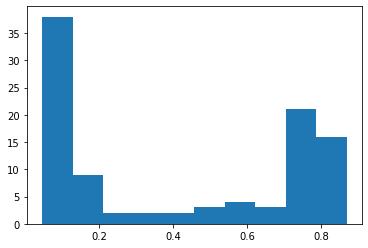

In [21]:
plt.hist(lfire_method.marginal[:,0]);

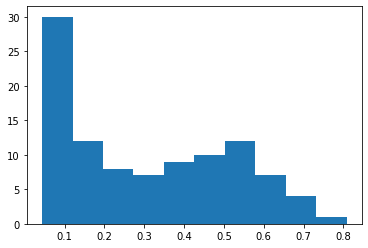

In [22]:
plt.hist(lfire_method.marginal[:,1]);

test with simulated observations:

In [23]:
%time y_1=Y.generate(with_values={'sigma': 1.0})

CPU times: user 29.2 s, sys: 89.6 ms, total: 29.3 s
Wall time: 29.9 s


In [24]:
np.std(y_1,axis=2)

array([[0.09644707, 0.1168691 ]])

posterior estimation:

In [25]:
%time post_1 = lfire_method.infer(observed =  {'Y': y_1})

Progress: |██████████████████████████████████████████████████| 100.0% Complete


 /Users/umvremes/anaconda/envs/bonfire_new/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


CPU times: user 1d 9h 14min 48s, sys: 8min 13s, total: 1d 9h 23min 1s
Wall time: 1d 11h 23min 50s


In [26]:
post_1.summary()

Method: LFIRE
Number of simulations: 3100
MAP estimates: sigma: 0.9
Posterior means: sigma: 0.935



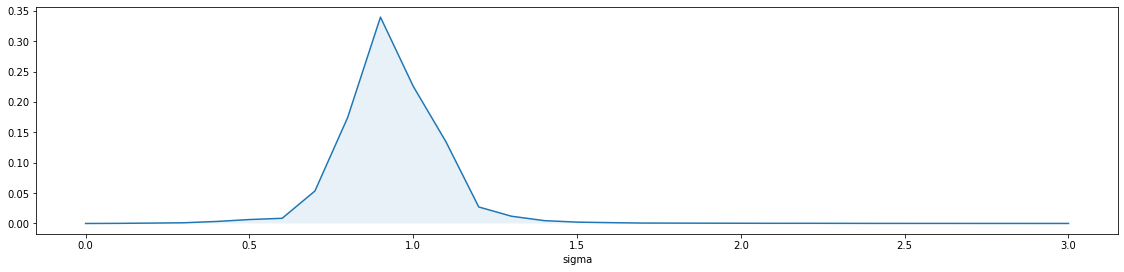

In [27]:
post_1.plot_marginals();

cls params:

In [28]:
np.median(lfire_method.state['param_array'],axis=0)

array([2.48017334, 0.4967466 , 0.23118054])

the posterior model can be saved:

In [29]:
lfire_method.save_models('driver_model_100_300.npz')

or used to calculate posterior probabilities based on other observations:

In [30]:
%time y_2=Y.generate(with_values={'sigma': 1.5})

CPU times: user 41.7 s, sys: 181 ms, total: 41.9 s
Wall time: 43.5 s


In [31]:
np.std(y_2,axis=2)

array([[0.56099337, 0.24021006]])

In [32]:
%time post_2 = lfire_method.infer(observed =  {'Y': y_2})

CPU times: user 36 ms, sys: 4.12 ms, total: 40.1 ms
Wall time: 29.5 ms


In [33]:
post_2.summary()

Method: LFIRE
Number of simulations: 3100
MAP estimates: sigma: 1.4
Posterior means: sigma: 1.35



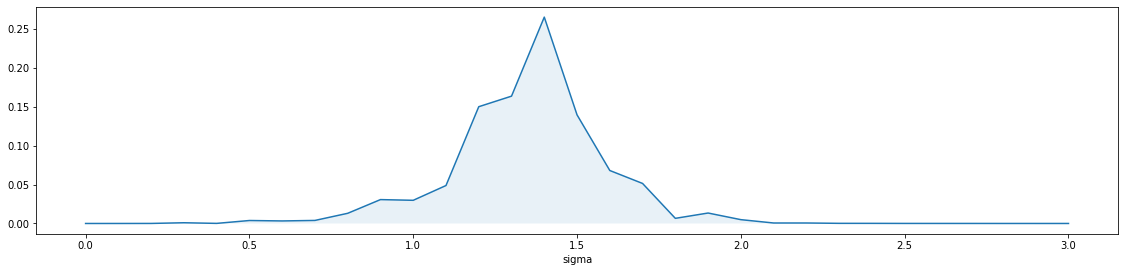

In [34]:
post_2.plot_marginals();